---
## 0. Imports y Configuración

In [5]:
# Imports estándar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
import warnings

# Redes
import igraph as ig
import networkx as nx

# Métricas de comparación de particiones
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Configuración
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

SEED = 42
np.random.seed(SEED)

print("✓ Librerías cargadas correctamente")

✓ Librerías cargadas correctamente


In [8]:
# Rutas de datos
DATA_DIR = Path('../data/processed')

# Cargar datos
edges_bipartita = pd.read_csv(DATA_DIR / 'edges_bipartita.csv')
datos_limpios = pd.read_csv(DATA_DIR / 'datos_limpios.csv')

print(f"edges_bipartita: {edges_bipartita.shape}")
print(f"datos_limpios: {datos_limpios.shape}")
print(f"\nColumnas edges_bipartita: {edges_bipartita.columns.tolist()}")
print(f"Columnas datos_limpios: {datos_limpios.columns.tolist()}")
print(f"\nAños disponibles: {sorted(edges_bipartita['anio'].unique())}")

edges_bipartita: (7258, 3)
datos_limpios: (7955, 6)

Columnas edges_bipartita: ['persona', 'servicio', 'anio']
Columnas datos_limpios: ['AÑO', 'PERSONA', 'TIPO DE SERVICIO', 'NOMBRE DE LA TAREA', 'MODALIDAD', 'COMPLEJIDAD']

Años disponibles: [np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]


---
## 1. Variantes de la Red

Cargamos la proyección cliente-cliente ponderada desde `proyeccion_cc_ponderada.csv` y generamos tres variantes:

1. **Ponderada**: peso = número de servicios compartidos (archivo original)
2. **No ponderada (binaria)**: todas las aristas con peso 1
3. **Jaccard normalizada**: $w_{ij}^{Jaccard} = \frac{|S_i \cap S_j|}{|S_i \cup S_j|}$

In [7]:
# Cargar proyección ponderada desde archivo existente
proyeccion = pd.read_csv(DATA_DIR / 'proyeccion_cc_ponderada.csv')

print(f"Proyección cargada desde proyeccion_cc_ponderada.csv")
print(f"Aristas: {len(proyeccion)}")
print(f"Columnas: {proyeccion.columns.tolist()}")
proyeccion.head()

Proyección cargada desde proyeccion_cc_ponderada.csv
Aristas: 7189307
Columnas: ['persona1', 'persona2', 'peso']


,persona1,persona2,peso
0,Id_5024,Id_2251,1
1,Id_5024,Id_3941,1
2,Id_5024,Id_4097,1
3,Id_5024,Id_4557,1
4,Id_5024,Id_1997,1


In [9]:
def crear_grafo_igraph(edges_df, peso_col='peso', weighted=True):
    """
    Crea un grafo igraph desde DataFrame de aristas.
    """
    # Obtener nodos únicos
    nodos = sorted(set(edges_df['persona1']) | set(edges_df['persona2']))
    nodo_a_idx = {n: i for i, n in enumerate(nodos)}
    
    # Crear aristas como tuplas de índices
    aristas = [(nodo_a_idx[r['persona1']], nodo_a_idx[r['persona2']]) 
               for _, r in edges_df.iterrows()]
    
    # Crear grafo
    g = ig.Graph(n=len(nodos), edges=aristas, directed=False)
    g.vs['name'] = nodos
    
    if weighted and peso_col in edges_df.columns:
        g.es['weight'] = edges_df[peso_col].tolist()
    else:
        g.es['weight'] = [1] * len(aristas)
    
    return g

# 1. Red ponderada (peso = servicios compartidos)
g_ponderada = crear_grafo_igraph(proyeccion, weighted=True)
print(f"Red Ponderada: {g_ponderada.vcount()} nodos, {g_ponderada.ecount()} aristas")
print(f"  - Peso min: {min(g_ponderada.es['weight'])}, max: {max(g_ponderada.es['weight'])}")

Red Ponderada: 5090 nodos, 7189307 aristas
  - Peso min: 1, max: 5


In [10]:
# 2. Red no ponderada (binaria)
g_binaria = g_ponderada.copy()
g_binaria.es['weight'] = [1] * g_binaria.ecount()
print(f"Red Binaria: {g_binaria.vcount()} nodos, {g_binaria.ecount()} aristas")

Red Binaria: 5090 nodos, 7189307 aristas


In [11]:
def calcular_peso_jaccard(df_bipartita, edges_df, persona_col='persona', servicio_col='servicio'):
    """
    Calcula peso Jaccard: |S_i ∩ S_j| / |S_i ∪ S_j|
    """
    # Conjunto de servicios por persona
    persona_servicios = df_bipartita.groupby(persona_col)[servicio_col].apply(set).to_dict()
    
    pesos_jaccard = []
    for _, row in edges_df.iterrows():
        p1, p2 = row['persona1'], row['persona2']
        s1 = persona_servicios.get(p1, set())
        s2 = persona_servicios.get(p2, set())
        
        interseccion = len(s1 & s2)
        union = len(s1 | s2)
        
        jaccard = interseccion / union if union > 0 else 0
        pesos_jaccard.append(jaccard)
    
    return pesos_jaccard

# 3. Red con peso Jaccard
proyeccion['peso_jaccard'] = calcular_peso_jaccard(edges_bipartita, proyeccion)
g_jaccard = crear_grafo_igraph(proyeccion, peso_col='peso_jaccard', weighted=True)
g_jaccard.es['weight'] = proyeccion['peso_jaccard'].tolist()

print(f"Red Jaccard: {g_jaccard.vcount()} nodos, {g_jaccard.ecount()} aristas")
print(f"  - Peso Jaccard min: {min(g_jaccard.es['weight']):.3f}, max: {max(g_jaccard.es['weight']):.3f}")

Red Jaccard: 5090 nodos, 7189307 aristas
  - Peso Jaccard min: 0.143, max: 1.000


In [12]:
# Resumen de variantes (3 variantes: Ponderada, Binaria, Jaccard)
variantes_resumen = pd.DataFrame({
    'Variante': ['Ponderada', 'Binaria', 'Jaccard'],
    'Nodos': [g_ponderada.vcount(), g_binaria.vcount(), g_jaccard.vcount()],
    'Aristas': [g_ponderada.ecount(), g_binaria.ecount(), g_jaccard.ecount()],
    'Peso_min': [
        min(g_ponderada.es['weight']),
        min(g_binaria.es['weight']),
        round(min(g_jaccard.es['weight']), 3)
    ],
    'Peso_max': [
        max(g_ponderada.es['weight']),
        max(g_binaria.es['weight']),
        round(max(g_jaccard.es['weight']), 3)
    ],
    'Peso_medio': [
        round(np.mean(g_ponderada.es['weight']), 2),
        round(np.mean(g_binaria.es['weight']), 2),
        round(np.mean(g_jaccard.es['weight']), 3)
    ]
})

print("\n=== RESUMEN DE VARIANTES DE RED ===")
variantes_resumen


=== RESUMEN DE VARIANTES DE RED ===


,Variante,Nodos,Aristas,Peso_min,Peso_max,Peso_medio
0,Ponderada,5090,7189307,1.000,5.0,1.030
1,Binaria,5090,7189307,1.000,1.0,1.000
2,Jaccard,5090,7189307,0.143,1.0,0.757


---
## 2. Detección de Comunidades

Aplicamos dos algoritmos:
- **Louvain** (multilevel community detection) – sobre la red completa
- **Girvan-Newman** (edge betweenness) – sobre un subgrafo pequeño para comparación

Usaremos la **red Jaccard** para la detección de comunidades ya que normaliza por el tamaño del portfolio de servicios.

In [13]:
# Louvain sobre red Jaccard
print("Ejecutando Louvain sobre red Jaccard...")
louvain_result = g_jaccard.community_multilevel(weights='weight')

# Asignar membresía a nodos
g_jaccard.vs['comunidad_louvain'] = louvain_result.membership

n_comunidades = len(set(louvain_result.membership))
modularidad = louvain_result.modularity

print(f"\n=== RESULTADOS LOUVAIN (Red Jaccard) ===")
print(f"Número de comunidades: {n_comunidades}")
print(f"Modularidad: {modularidad:.4f}")

Ejecutando Louvain sobre red Jaccard...

=== RESULTADOS LOUVAIN (Red Jaccard) ===
Número de comunidades: 3
Modularidad: 0.3832



Distribución de tamaños de comunidades:
 Comunidad  Tamaño
         0    2412
         1    2352
         2     326


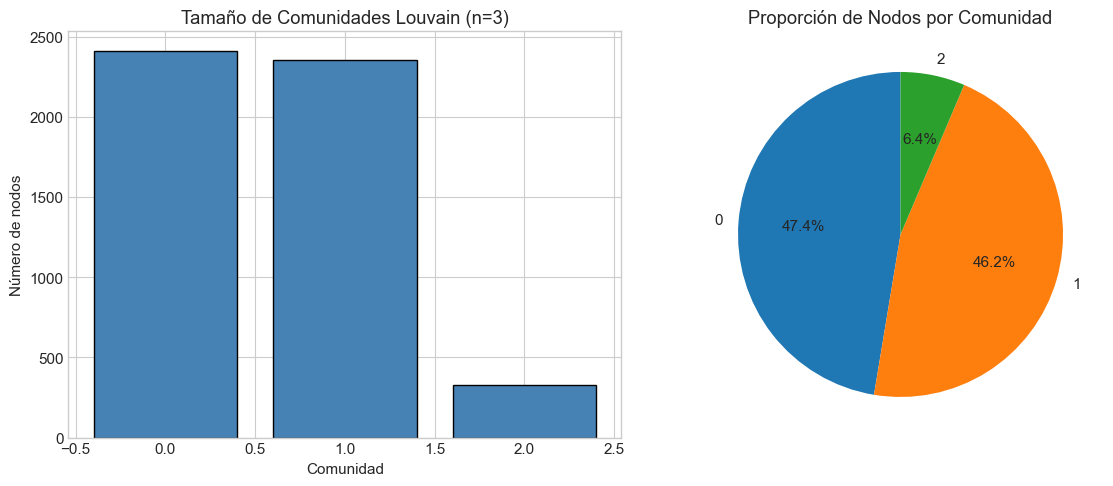

In [14]:
# Distribución de tamaños de comunidades
tamaños_comunidades = Counter(louvain_result.membership)
tamaños_df = pd.DataFrame([
    {'Comunidad': k, 'Tamaño': v} 
    for k, v in sorted(tamaños_comunidades.items())
])

print("\nDistribución de tamaños de comunidades:")
print(tamaños_df.to_string(index=False))

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Barras de tamaño
axes[0].bar(tamaños_df['Comunidad'], tamaños_df['Tamaño'], color='steelblue', edgecolor='black')
axes[0].set_xlabel('Comunidad')
axes[0].set_ylabel('Número de nodos')
axes[0].set_title(f'Tamaño de Comunidades Louvain (n={n_comunidades})')

# Pie chart
if n_comunidades <= 10:
    axes[1].pie(tamaños_df['Tamaño'], labels=tamaños_df['Comunidad'], autopct='%1.1f%%', startangle=90)
    axes[1].set_title('Proporción de Nodos por Comunidad')
else:
    # Histograma de tamaños si hay muchas comunidades
    axes[1].hist(tamaños_df['Tamaño'], bins=20, color='steelblue', edgecolor='black')
    axes[1].set_xlabel('Tamaño de comunidad')
    axes[1].set_ylabel('Frecuencia')
    axes[1].set_title('Distribución de Tamaños de Comunidad')

plt.tight_layout()
plt.savefig('../reports/figures/comunidades_louvain_distribucion.png', dpi=150, bbox_inches='tight')
plt.show()

In [15]:
# Girvan-Newman sobre subgrafo (computacionalmente costoso, usamos subgrafo pequeño)
print("Ejecutando Girvan-Newman sobre subgrafo...")

# Seleccionar subgrafo: comunidad más pequeña o muestra aleatoria
if g_jaccard.vcount() > 100:
    # Tomar una muestra de 100 nodos
    np.random.seed(SEED)
    nodos_muestra = np.random.choice(g_jaccard.vcount(), size=min(100, g_jaccard.vcount()), replace=False)
    g_subgrafo = g_jaccard.subgraph(nodos_muestra)
else:
    g_subgrafo = g_jaccard.copy()

print(f"Subgrafo: {g_subgrafo.vcount()} nodos, {g_subgrafo.ecount()} aristas")

# Girvan-Newman
if g_subgrafo.ecount() > 0:
    gn_result = g_subgrafo.community_edge_betweenness(weights='weight')
    gn_clusters = gn_result.as_clustering()
    
    n_comunidades_gn = len(set(gn_clusters.membership))
    modularidad_gn = gn_clusters.modularity
    
    print(f"\n=== RESULTADOS GIRVAN-NEWMAN (Subgrafo) ===")
    print(f"Número de comunidades: {n_comunidades_gn}")
    print(f"Modularidad: {modularidad_gn:.4f}")
else:
    print("Subgrafo sin aristas, no se puede ejecutar Girvan-Newman")
    n_comunidades_gn = 0
    modularidad_gn = np.nan

Ejecutando Girvan-Newman sobre subgrafo...
Subgrafo: 100 nodos, 2988 aristas

=== RESULTADOS GIRVAN-NEWMAN (Subgrafo) ===
Número de comunidades: 4
Modularidad: 0.3533


In [16]:
# Comparación de algoritmos
comparacion_algoritmos = pd.DataFrame({
    'Algoritmo': ['Louvain', 'Girvan-Newman'],
    'Red/Subgrafo': ['Jaccard completa', f'Subgrafo ({g_subgrafo.vcount()} nodos)'],
    'Comunidades': [n_comunidades, n_comunidades_gn],
    'Modularidad': [round(modularidad, 4), round(modularidad_gn, 4) if not np.isnan(modularidad_gn) else np.nan]
})

print("\n=== COMPARACIÓN DE ALGORITMOS ===")
comparacion_algoritmos


=== COMPARACIÓN DE ALGORITMOS ===


,Algoritmo,Red/Subgrafo,Comunidades,Modularidad
0,Louvain,Jaccard completa,3,0.3832
1,Girvan-Newman,Subgrafo (100 nodos),4,0.3533


---
## 3. Análisis Temporal

Construimos redes por año y comparamos las particiones usando:
- **ARI** (Adjusted Rand Index)
- **NMI** (Normalized Mutual Information)

In [17]:
from itertools import combinations

def construir_proyeccion_ponderada(df_bipartita, persona_col='persona', servicio_col='servicio'):
    """
    Construye la proyección unimodal de personas conectadas por servicios compartidos.
    Peso = número de servicios en común.
    """
    servicio_personas = df_bipartita.groupby(servicio_col)[persona_col].apply(set).to_dict()
    edge_counts = Counter()
    
    for servicio, personas in servicio_personas.items():
        for p1, p2 in combinations(sorted(personas), 2):
            edge_counts[(p1, p2)] += 1
    
    edges_df = pd.DataFrame([
        {'persona1': p1, 'persona2': p2, 'peso': count}
        for (p1, p2), count in edge_counts.items()
    ])
    return edges_df

def construir_red_anual(df_bipartita, anio):
    """
    Construye la proyección para un año específico.
    """
    df_anio = df_bipartita[df_bipartita['anio'] == anio]
    if len(df_anio) == 0:
        return None, None
    
    proyeccion_anio = construir_proyeccion_ponderada(df_anio)
    if len(proyeccion_anio) == 0:
        return None, None
        
    # Calcular Jaccard
    proyeccion_anio['peso_jaccard'] = calcular_peso_jaccard(df_anio, proyeccion_anio)
    g_anio = crear_grafo_igraph(proyeccion_anio, peso_col='peso_jaccard', weighted=True)
    g_anio.es['weight'] = proyeccion_anio['peso_jaccard'].tolist()
    
    return g_anio, proyeccion_anio

# Construir redes anuales
anios = sorted(edges_bipartita['anio'].unique())
redes_anuales = {}
comunidades_anuales = {}

print("Construyendo redes anuales...")
for anio in anios:
    g_anio, proy_anio = construir_red_anual(edges_bipartita, anio)
    if g_anio is not None and g_anio.vcount() > 0 and g_anio.ecount() > 0:
        redes_anuales[anio] = g_anio
        # Detectar comunidades
        louvain_anio = g_anio.community_multilevel(weights='weight')
        comunidades_anuales[anio] = {
            'particion': louvain_anio,
            'n_comunidades': len(set(louvain_anio.membership)),
            'modularidad': louvain_anio.modularity,
            'nodos': g_anio.vs['name'],
            'membership': louvain_anio.membership
        }
        print(f"  {anio}: {g_anio.vcount()} nodos, {g_anio.ecount()} aristas, {comunidades_anuales[anio]['n_comunidades']} comunidades")
    else:
        print(f"  {anio}: Sin datos suficientes")

Construyendo redes anuales...
  2019: 298 nodos, 44253 aristas, 1 comunidades
  2019: 298 nodos, 44253 aristas, 1 comunidades
  2020: 806 nodos, 207212 aristas, 3 comunidades
  2020: 806 nodos, 207212 aristas, 3 comunidades
  2021: 2386 nodos, 1629741 aristas, 3 comunidades
  2021: 2386 nodos, 1629741 aristas, 3 comunidades
  2022: 1557 nodos, 601274 aristas, 4 comunidades
  2022: 1557 nodos, 601274 aristas, 4 comunidades
  2023: 711 nodos, 152168 aristas, 4 comunidades
  2023: 711 nodos, 152168 aristas, 4 comunidades
  2024: 375 nodos, 30630 aristas, 6 comunidades
  2024: 375 nodos, 30630 aristas, 6 comunidades


In [18]:
# Resumen de redes anuales
redes_anuales_df = pd.DataFrame([
    {
        'Año': anio,
        'Nodos': redes_anuales[anio].vcount(),
        'Aristas': redes_anuales[anio].ecount(),
        'Comunidades': comunidades_anuales[anio]['n_comunidades'],
        'Modularidad': round(comunidades_anuales[anio]['modularidad'], 4)
    }
    for anio in sorted(redes_anuales.keys())
])

print("\n=== RESUMEN DE REDES ANUALES ===")
redes_anuales_df


=== RESUMEN DE REDES ANUALES ===


,Año,Nodos,Aristas,Comunidades,Modularidad
0,2019,298,44253,1,0.0000
1,2020,806,207212,3,0.1936
2,2021,2386,1629741,3,0.3062
3,2022,1557,601274,4,0.3204
4,2023,711,152168,4,0.3382
5,2024,375,30630,6,0.4055


In [19]:
def calcular_similaridad_particiones(com1, com2):
    """
    Calcula ARI y NMI entre dos particiones.
    Solo considera nodos comunes entre ambos años.
    """
    nodos1 = set(com1['nodos'])
    nodos2 = set(com2['nodos'])
    nodos_comunes = nodos1 & nodos2
    
    if len(nodos_comunes) < 2:
        return np.nan, np.nan, 0
    
    # Mapear membresía para nodos comunes
    memb1 = {n: m for n, m in zip(com1['nodos'], com1['membership'])}
    memb2 = {n: m for n, m in zip(com2['nodos'], com2['membership'])}
    
    nodos_lista = sorted(nodos_comunes)
    labels1 = [memb1[n] for n in nodos_lista]
    labels2 = [memb2[n] for n in nodos_lista]
    
    ari = adjusted_rand_score(labels1, labels2)
    nmi = normalized_mutual_info_score(labels1, labels2)
    
    return ari, nmi, len(nodos_comunes)

# Calcular ARI/NMI entre años consecutivos
anios_ordenados = sorted(comunidades_anuales.keys())
comparaciones = []

print("\nComparando particiones entre años consecutivos...")
for i in range(len(anios_ordenados) - 1):
    anio1 = anios_ordenados[i]
    anio2 = anios_ordenados[i + 1]
    
    ari, nmi, n_comunes = calcular_similaridad_particiones(
        comunidades_anuales[anio1],
        comunidades_anuales[anio2]
    )
    
    comparaciones.append({
        'Años': f"{anio1}-{anio2}",
        'Nodos_comunes': n_comunes,
        'ARI': round(ari, 4) if not np.isnan(ari) else np.nan,
        'NMI': round(nmi, 4) if not np.isnan(nmi) else np.nan
    })

comparaciones_df = pd.DataFrame(comparaciones)
print("\n=== ESTABILIDAD TEMPORAL (ARI/NMI) ===")
comparaciones_df


Comparando particiones entre años consecutivos...

=== ESTABILIDAD TEMPORAL (ARI/NMI) ===


,Años,Nodos_comunes,ARI,NMI
0,2019-2020,43,0.0000,0.0000
1,2020-2021,185,0.0050,0.0100
2,2021-2022,289,-0.0252,0.0127
3,2022-2023,227,0.1237,0.1243
4,2023-2024,117,0.0340,0.1368


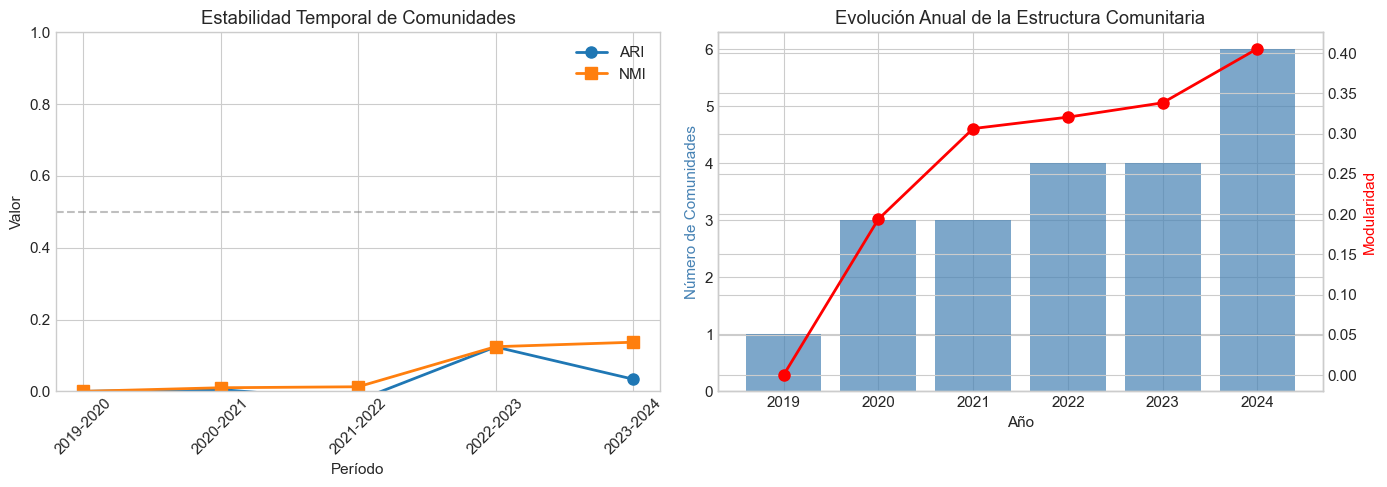

In [20]:
# Visualización de estabilidad temporal
if len(comparaciones_df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Gráfico de líneas ARI/NMI
    x = range(len(comparaciones_df))
    axes[0].plot(x, comparaciones_df['ARI'], 'o-', label='ARI', linewidth=2, markersize=8)
    axes[0].plot(x, comparaciones_df['NMI'], 's-', label='NMI', linewidth=2, markersize=8)
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(comparaciones_df['Años'], rotation=45)
    axes[0].set_xlabel('Período')
    axes[0].set_ylabel('Valor')
    axes[0].set_title('Estabilidad Temporal de Comunidades')
    axes[0].legend()
    axes[0].set_ylim(0, 1)
    axes[0].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
    
    # Evolución de número de comunidades y modularidad
    ax2 = axes[1]
    ax2_twin = ax2.twinx()
    
    ax2.bar(redes_anuales_df['Año'].astype(str), redes_anuales_df['Comunidades'], 
            color='steelblue', alpha=0.7, label='Comunidades')
    ax2_twin.plot(redes_anuales_df['Año'].astype(str), redes_anuales_df['Modularidad'], 
                  'ro-', linewidth=2, markersize=8, label='Modularidad')
    
    ax2.set_xlabel('Año')
    ax2.set_ylabel('Número de Comunidades', color='steelblue')
    ax2_twin.set_ylabel('Modularidad', color='red')
    ax2.set_title('Evolución Anual de la Estructura Comunitaria')
    
    plt.tight_layout()
    plt.savefig('../reports/figures/estabilidad_temporal.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("No hay suficientes años para comparar")

---
## 4. Estadísticas de Comunidades

Calculamos métricas internas para cada comunidad:
- Tamaño
- Densidad interna
- Grado promedio interno
- Coeficiente de clustering interno

In [21]:
def calcular_metricas_comunidad(g, membership):
    """
    Calcula métricas internas para cada comunidad.
    """
    comunidades = set(membership)
    metricas = []
    
    for com_id in sorted(comunidades):
        # Obtener nodos de la comunidad
        nodos_com = [i for i, m in enumerate(membership) if m == com_id]
        n_nodos = len(nodos_com)
        
        if n_nodos < 2:
            metricas.append({
                'Comunidad': com_id,
                'Tamaño': n_nodos,
                'Aristas_internas': 0,
                'Densidad': 0,
                'Grado_medio_interno': 0,
                'Clustering_interno': 0
            })
            continue
        
        # Subgrafo de la comunidad
        subg = g.subgraph(nodos_com)
        n_aristas = subg.ecount()
        
        # Densidad
        max_aristas = n_nodos * (n_nodos - 1) / 2
        densidad = n_aristas / max_aristas if max_aristas > 0 else 0
        
        # Grado promedio interno
        grados = subg.degree()
        grado_medio = np.mean(grados) if grados else 0
        
        # Clustering interno
        clustering = subg.transitivity_avglocal_undirected(mode='zero')
        
        metricas.append({
            'Comunidad': com_id,
            'Tamaño': n_nodos,
            'Aristas_internas': n_aristas,
            'Densidad': round(densidad, 4),
            'Grado_medio_interno': round(grado_medio, 2),
            'Clustering_interno': round(clustering, 4)
        })
    
    return pd.DataFrame(metricas)

# Calcular métricas para la red global
metricas_comunidades = calcular_metricas_comunidad(g_jaccard, louvain_result.membership)

print("\n=== MÉTRICAS POR COMUNIDAD (Red Jaccard Global) ===")
metricas_comunidades


=== MÉTRICAS POR COMUNIDAD (Red Jaccard Global) ===


,Comunidad,Tamaño,Aristas_internas,Densidad,Grado_medio_interno,Clustering_interno
0,0,2412,2907666,1.0000,2411.00,1.0000
1,1,2352,2764776,1.0000,2351.00,1.0000
2,2,326,22855,0.4314,140.21,0.9728



=== ESTADÍSTICAS AGREGADAS ===
Tamaño promedio de comunidad: 1696.7 ± 1187.4
Densidad promedio interna: 0.8105
Clustering promedio interno: 0.9909


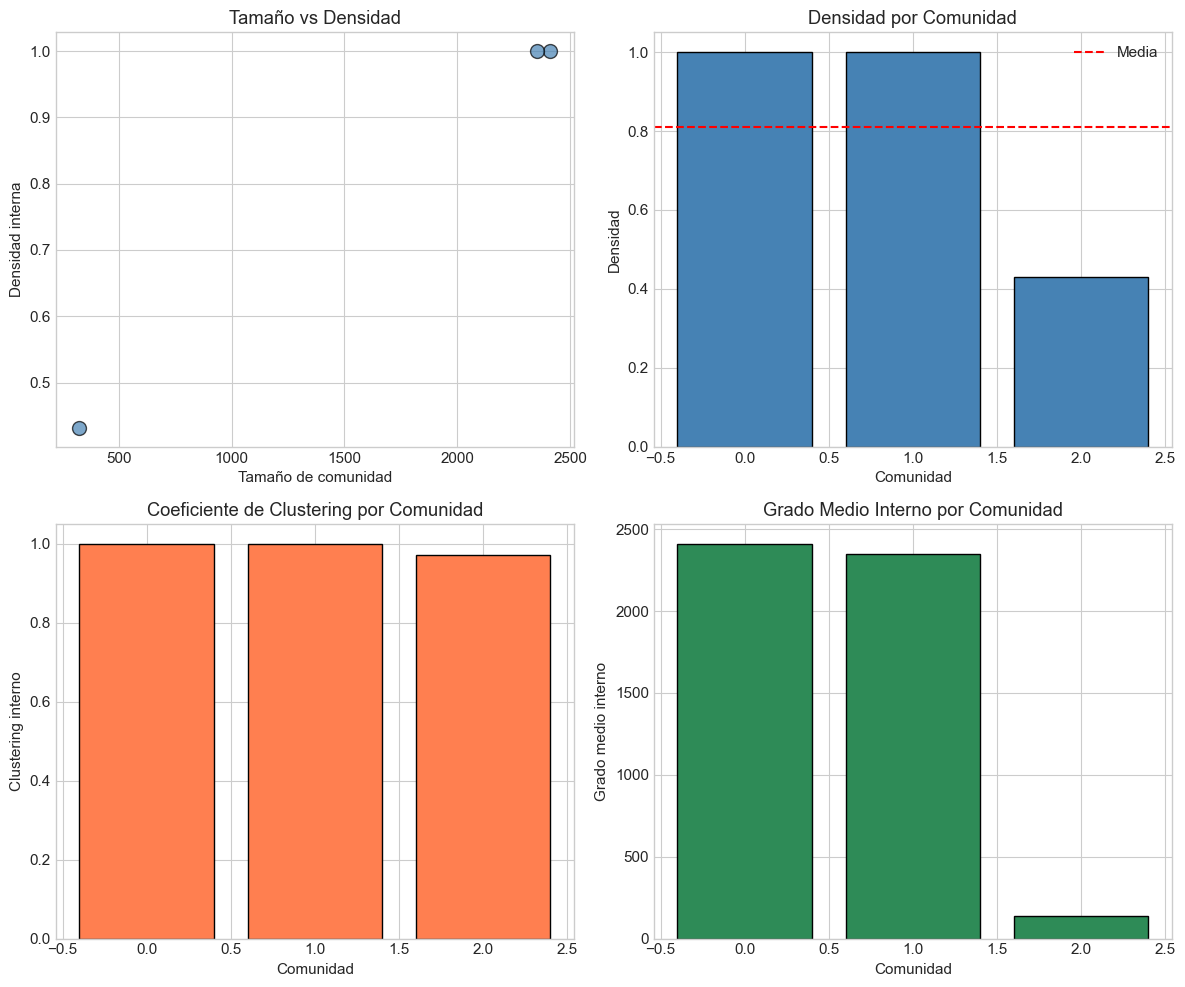

In [22]:
# Estadísticas agregadas
print("\n=== ESTADÍSTICAS AGREGADAS ===")
print(f"Tamaño promedio de comunidad: {metricas_comunidades['Tamaño'].mean():.1f} ± {metricas_comunidades['Tamaño'].std():.1f}")
print(f"Densidad promedio interna: {metricas_comunidades['Densidad'].mean():.4f}")
print(f"Clustering promedio interno: {metricas_comunidades['Clustering_interno'].mean():.4f}")

# Visualización
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Tamaño vs Densidad
axes[0, 0].scatter(metricas_comunidades['Tamaño'], metricas_comunidades['Densidad'], 
                   s=100, c='steelblue', alpha=0.7, edgecolors='black')
axes[0, 0].set_xlabel('Tamaño de comunidad')
axes[0, 0].set_ylabel('Densidad interna')
axes[0, 0].set_title('Tamaño vs Densidad')

# Densidad por comunidad
axes[0, 1].bar(metricas_comunidades['Comunidad'], metricas_comunidades['Densidad'],
               color='steelblue', edgecolor='black')
axes[0, 1].set_xlabel('Comunidad')
axes[0, 1].set_ylabel('Densidad')
axes[0, 1].set_title('Densidad por Comunidad')
axes[0, 1].axhline(y=metricas_comunidades['Densidad'].mean(), color='red', linestyle='--', label='Media')
axes[0, 1].legend()

# Clustering por comunidad
axes[1, 0].bar(metricas_comunidades['Comunidad'], metricas_comunidades['Clustering_interno'],
               color='coral', edgecolor='black')
axes[1, 0].set_xlabel('Comunidad')
axes[1, 0].set_ylabel('Clustering interno')
axes[1, 0].set_title('Coeficiente de Clustering por Comunidad')

# Grado medio por comunidad
axes[1, 1].bar(metricas_comunidades['Comunidad'], metricas_comunidades['Grado_medio_interno'],
               color='seagreen', edgecolor='black')
axes[1, 1].set_xlabel('Comunidad')
axes[1, 1].set_ylabel('Grado medio interno')
axes[1, 1].set_title('Grado Medio Interno por Comunidad')

plt.tight_layout()
plt.savefig('../reports/figures/metricas_comunidades.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 5. Caracterización Semántica

Para cada comunidad, identificamos los atributos dominantes:
- **Modalidad** (Presencial/Virtual)
- **Complejidad** (Baja/Media/Alta)

Cruzamos la membresía de comunidad con los atributos de `datos_limpios.csv`.

In [23]:
# Crear mapeo persona -> comunidad
persona_comunidad = {name: com for name, com in zip(g_jaccard.vs['name'], louvain_result.membership)}

# Agregar comunidad a datos limpios
datos_con_comunidad = datos_limpios.copy()
datos_con_comunidad['comunidad'] = datos_con_comunidad['PERSONA'].map(persona_comunidad)

# Eliminar filas sin comunidad asignada (personas que no están en la red)
datos_con_comunidad = datos_con_comunidad.dropna(subset=['comunidad'])
datos_con_comunidad['comunidad'] = datos_con_comunidad['comunidad'].astype(int)

print(f"Registros con comunidad asignada: {len(datos_con_comunidad)} / {len(datos_limpios)}")
datos_con_comunidad.head()

Registros con comunidad asignada: 7955 / 7955


,AÑO,PERSONA,TIPO DE SERVICIO,NOMBRE DE LA TAREA,MODALIDAD,COMPLEJIDAD,comunidad
0,2019,Id_1,Serv_1,Tarea_1.1,Presencial,Baja,0
1,2019,Id_2,Serv_1,Tarea_1.1,Presencial,Baja,0
2,2019,Id_3,Serv_1,Tarea_1.1,Presencial,Baja,0
3,2019,Id_4,Serv_1,Tarea_1.1,Presencial,Baja,0
4,2019,Id_5,Serv_1,Tarea_1.1,Presencial,Baja,0


In [24]:
def caracterizar_comunidad(df, comunidad_col='comunidad', atributos=['MODALIDAD', 'COMPLEJIDAD']):
    """
    Calcula la distribución de atributos por comunidad y determina el valor dominante.
    """
    resultados = []
    
    for com_id in sorted(df[comunidad_col].unique()):
        df_com = df[df[comunidad_col] == com_id]
        n_registros = len(df_com)
        n_personas = df_com['PERSONA'].nunique()
        
        fila = {
            'Comunidad': com_id,
            'N_registros': n_registros,
            'N_personas': n_personas
        }
        
        for attr in atributos:
            if attr in df_com.columns:
                # Distribución
                dist = df_com[attr].value_counts(normalize=True)
                # Valor dominante
                dominante = dist.idxmax()
                prop_dominante = dist.max()
                
                fila[f'{attr}_dominante'] = dominante
                fila[f'{attr}_prop'] = round(prop_dominante, 3)
        
        resultados.append(fila)
    
    return pd.DataFrame(resultados)

# Caracterizar comunidades
caracterizacion = caracterizar_comunidad(datos_con_comunidad)

print("\n=== CARACTERIZACIÓN SEMÁNTICA DE COMUNIDADES ===")
caracterizacion


=== CARACTERIZACIÓN SEMÁNTICA DE COMUNIDADES ===


,Comunidad,N_registros,N_personas,MODALIDAD_dominante,MODALIDAD_prop,COMPLEJIDAD_dominante,COMPLEJIDAD_prop
0,0,4656,2412,Virtual,0.643,Baja,0.857
1,1,2906,2352,Virtual,0.549,Baja,0.569
2,2,393,326,Presencial,0.947,Mediana,0.690


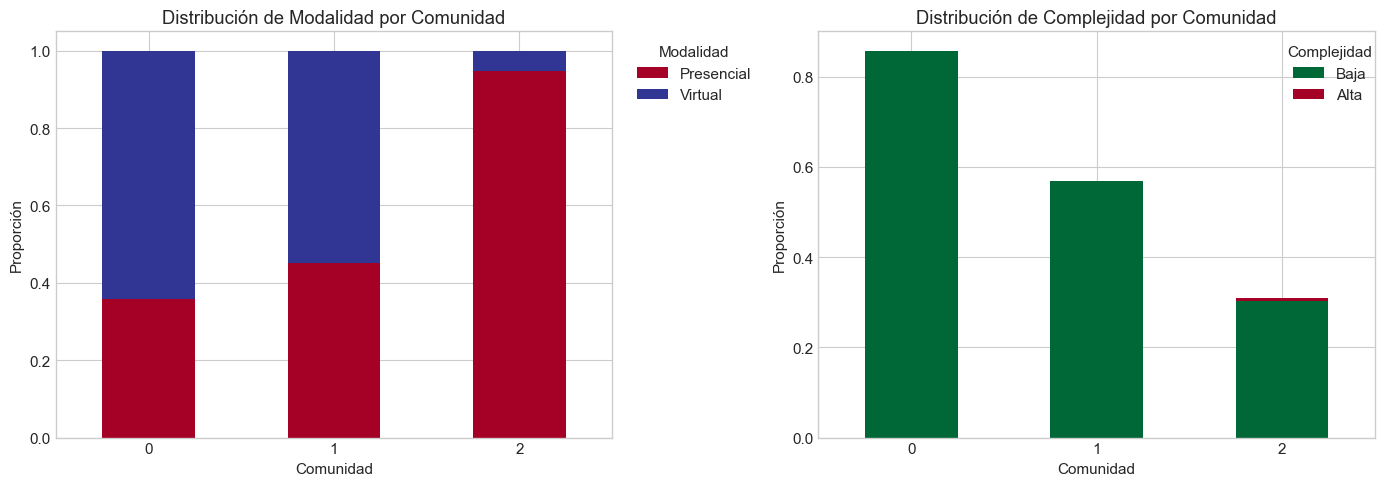

In [25]:
# Visualización de caracterización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribución de Modalidad por comunidad
modalidad_pivot = datos_con_comunidad.groupby(['comunidad', 'MODALIDAD']).size().unstack(fill_value=0)
modalidad_norm = modalidad_pivot.div(modalidad_pivot.sum(axis=1), axis=0)

modalidad_norm.plot(kind='bar', stacked=True, ax=axes[0], colormap='RdYlBu')
axes[0].set_xlabel('Comunidad')
axes[0].set_ylabel('Proporción')
axes[0].set_title('Distribución de Modalidad por Comunidad')
axes[0].legend(title='Modalidad', bbox_to_anchor=(1.02, 1))
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# Distribución de Complejidad por comunidad
complejidad_pivot = datos_con_comunidad.groupby(['comunidad', 'COMPLEJIDAD']).size().unstack(fill_value=0)
complejidad_norm = complejidad_pivot.div(complejidad_pivot.sum(axis=1), axis=0)

# Ordenar columnas si existen
orden_complejidad = ['Baja', 'Media', 'Alta']
cols_existentes = [c for c in orden_complejidad if c in complejidad_norm.columns]
if cols_existentes:
    complejidad_norm = complejidad_norm[cols_existentes]

complejidad_norm.plot(kind='bar', stacked=True, ax=axes[1], colormap='RdYlGn_r')
axes[1].set_xlabel('Comunidad')
axes[1].set_ylabel('Proporción')
axes[1].set_title('Distribución de Complejidad por Comunidad')
axes[1].legend(title='Complejidad', bbox_to_anchor=(1.02, 1))
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.savefig('../reports/figures/caracterizacion_semantica.png', dpi=150, bbox_inches='tight')
plt.show()

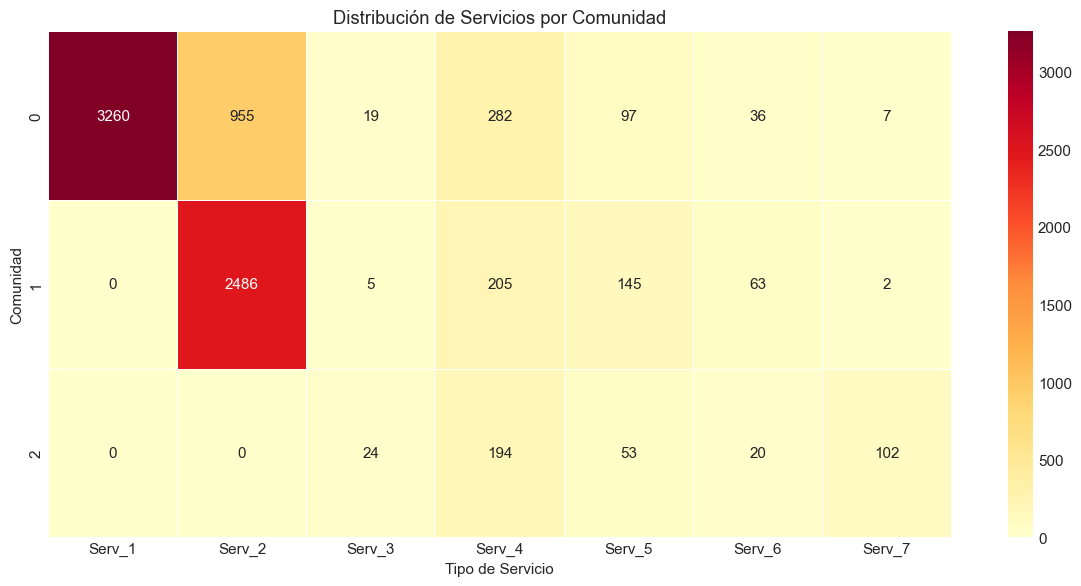

In [26]:
# Heatmap de servicios por comunidad
servicios_comunidad = datos_con_comunidad.groupby(['comunidad', 'TIPO DE SERVICIO']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
sns.heatmap(servicios_comunidad, cmap='YlOrRd', annot=True, fmt='d', linewidths=0.5)
plt.title('Distribución de Servicios por Comunidad')
plt.xlabel('Tipo de Servicio')
plt.ylabel('Comunidad')
plt.tight_layout()
plt.savefig('../reports/figures/heatmap_servicios_comunidad.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 6. Resumen para el Informe

In [27]:
# Tabla resumen final
resumen_final = caracterizacion.merge(metricas_comunidades, on='Comunidad', how='left')

# Reordenar columnas
cols_orden = ['Comunidad', 'Tamaño', 'N_personas', 'N_registros', 'Densidad', 
              'Clustering_interno', 'MODALIDAD_dominante', 'MODALIDAD_prop',
              'COMPLEJIDAD_dominante', 'COMPLEJIDAD_prop']
cols_existentes = [c for c in cols_orden if c in resumen_final.columns]
resumen_final = resumen_final[cols_existentes]

print("\n" + "="*80)
print("TABLA RESUMEN FINAL: COMUNIDADES DETECTADAS")
print("="*80)
resumen_final


TABLA RESUMEN FINAL: COMUNIDADES DETECTADAS


,Comunidad,Tamaño,N_personas,N_registros,Densidad,Clustering_interno,MODALIDAD_dominante,MODALIDAD_prop,COMPLEJIDAD_dominante,COMPLEJIDAD_prop
0,0,2412,2412,4656,1.0000,1.0000,Virtual,0.643,Baja,0.857
1,1,2352,2352,2906,1.0000,1.0000,Virtual,0.549,Baja,0.569
2,2,326,326,393,0.4314,0.9728,Presencial,0.947,Mediana,0.690


In [28]:
# Guardar tabla resumen
resumen_final.to_csv('../reports/comunidades_resumen.csv', index=False)
print("\n✓ Tabla guardada en reports/comunidades_resumen.csv")


✓ Tabla guardada en reports/comunidades_resumen.csv


In [35]:
# Resumen ejecutivo
print("\n" + "="*80)
print("RESUMEN EJECUTIVO")
print("="*80)

# Calcular métricas temporales
if len(comparaciones_df) > 0:
    ari_promedio = f"{comparaciones_df['ARI'].mean():.4f}"
    nmi_promedio = f"{comparaciones_df['NMI'].mean():.4f}"
    interpretacion = 'Alta estabilidad temporal' if comparaciones_df['ARI'].mean() > 0.5 else 'Estructura cambiante'
else:
    ari_promedio = 'N/A'
    nmi_promedio = 'N/A'
    interpretacion = 'N/A'

print(f"""
RED ANALIZADA:
- Tipo: Proyección unimodal de clientes conectados por servicios compartidos
- Variante principal: Jaccard (normalizada por tamaño de portfolio)
- Nodos (clientes): {g_jaccard.vcount()}
- Aristas (conexiones): {g_jaccard.ecount()}

DETECCIÓN DE COMUNIDADES (Louvain):
- Número de comunidades: {n_comunidades}
- Modularidad: {modularidad:.4f}
- Tamaño promedio: {metricas_comunidades['Tamaño'].mean():.1f} clientes
- Densidad interna promedio: {metricas_comunidades['Densidad'].mean():.4f}

ANÁLISIS TEMPORAL ({len(anios_ordenados)} años: {min(anios_ordenados)}-{max(anios_ordenados)}):
- ARI promedio entre años consecutivos: {ari_promedio}
- NMI promedio entre años consecutivos: {nmi_promedio}
- Interpretación: {interpretacion}

CARACTERIZACIÓN SEMÁNTICA:
- Las comunidades muestran patrones diferenciados en Modalidad y Complejidad
- Ver tabla resumen_final para detalles por comunidad
""")


RESUMEN EJECUTIVO

RED ANALIZADA:
- Tipo: Proyección unimodal de clientes conectados por servicios compartidos
- Variante principal: Jaccard (normalizada por tamaño de portfolio)
- Nodos (clientes): 5090
- Aristas (conexiones): 7189307

DETECCIÓN DE COMUNIDADES (Louvain):
- Número de comunidades: 3
- Modularidad: 0.3832
- Tamaño promedio: 1696.7 clientes
- Densidad interna promedio: 0.8105

ANÁLISIS TEMPORAL (6 años: 2019-2024):
- ARI promedio entre años consecutivos: 0.0275
- NMI promedio entre años consecutivos: 0.0568
- Interpretación: Estructura cambiante

CARACTERIZACIÓN SEMÁNTICA:
- Las comunidades muestran patrones diferenciados en Modalidad y Complejidad
- Ver tabla resumen_final para detalles por comunidad



In [32]:
# Limitaciones y trabajo futuro
print("\n" + "="*80)
print("LIMITACIONES Y TRABAJO FUTURO")
print("="*80)

print("""
1. LIMITACIONES DEL ANÁLISIS ACTUAL:
   - Jaccard calculado sobre toda la ventana temporal (no por año)
   - Girvan-Newman aplicado solo a subgrafo por costo computacional
   - No se realizó análisis pre/post pandemia explícito

2. EXTENSIONES POSIBLES:
   - Calcular peso Jaccard por año para análisis temporal más fino
   - Implementar otros algoritmos (Infomap, Label Propagation)
   - Análisis de centralidad por comunidad
   - Detección de comunidades solapantes (overlapping communities)
   - Análisis de la evolución de clientes individuales entre comunidades

3. FIGURAS GENERADAS:
   - reports/figures/comunidades_louvain_distribucion.png
   - reports/figures/estabilidad_temporal.png
   - reports/figures/metricas_comunidades.png
   - reports/figures/caracterizacion_semantica.png
   - reports/figures/heatmap_servicios_comunidad.png
""")


LIMITACIONES Y TRABAJO FUTURO

1. LIMITACIONES DEL ANÁLISIS ACTUAL:
   - Jaccard calculado sobre toda la ventana temporal (no por año)
   - Girvan-Newman aplicado solo a subgrafo por costo computacional
   - No se realizó análisis pre/post pandemia explícito

2. EXTENSIONES POSIBLES:
   - Calcular peso Jaccard por año para análisis temporal más fino
   - Implementar otros algoritmos (Infomap, Label Propagation)
   - Análisis de centralidad por comunidad
   - Detección de comunidades solapantes (overlapping communities)
   - Análisis de la evolución de clientes individuales entre comunidades

3. FIGURAS GENERADAS:
   - reports/figures/comunidades_louvain_distribucion.png
   - reports/figures/estabilidad_temporal.png
   - reports/figures/metricas_comunidades.png
   - reports/figures/caracterizacion_semantica.png
   - reports/figures/heatmap_servicios_comunidad.png



---
## Fin del Análisis

Este notebook implementa el análisis completo de comunidades para el trabajo final de Redes Complejas.

**Archivos generados:**
- `reports/comunidades_resumen.csv` – Tabla resumen de comunidades
- `reports/figures/*.png` – Visualizaciones